# Sentiment Analysis with LSTMs

# Deep Learning for NLP 

# Word Vectors

# Word2Vec

# Recurrent Neural Networks (RNNs)

# Long Short Term Memory Units (LSTMs) 

# Framing Sentiment Analysis as a Deep Learning Problem

As mentioned before, the task of sentiment analysis involves taking in an input sequence of words and determining whether the sentiment is positive, negative, or neutral. We can separate this specific task (and most other NLP tasks) into 5 different components.

    1) Training a word vector generation model (such as Word2Vec) or loading pretrained word vectors
    2) Creating an ID's matrix for our training set (We'll discuss this a bit later)
    3) RNN (With LSTM units) graph creation
    4) Training 
    5) Testing

# Loading Data 

First, we want to create our word vectors. For simplicity, we're going to be using a pretrained model. 

As one of the biggest players in the ML game, Google was able to train a Word2Vec model on a massive Google News dataset that contained over 100 billion different words! From that model, Google [was able to create 3 million word vectors](https://code.google.com/archive/p/word2vec/#Pre-trained_word_and_phrase_vectors), each with a dimensionality of 300. 

In an ideal scenario, we'd use those vectors, but since the word vectors matrix is quite large (3.6 GB!), we'll be using a much more manageable matrix that is trained using [GloVe](http://nlp.stanford.edu/projects/glove/), a similar word vector generation model. The matrix will contain 400,000 word vectors, each with a dimensionality of 50. 

We're going to be importing two different data structures, one will be a Python list with the 400,000 words, and one will be a 400,000 x 50 dimensional embedding matrix that holds all of the word vector values. 

In [1]:
import numpy as np
wordsList = np.load('wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('wordVectors.npy')
print ('Loaded the word vectors!')

Loaded the word list!
Loaded the word vectors!


Just to make sure everything has been loaded in correctly, we can look at the dimensions of the vocabulary list and the embedding matrix. 

We can also search our word list for a word like "baseball", and then access its corresponding vector through the embedding matrix.

In [2]:
import tensorflow as tf

/home/ak/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
numDimensions = 300 #Dimensions for each word vector

The data pipeline can be illustrated below.

![caption](Images/SentimentAnalysis5.png)

The 10 x 50 output should contain the 50 dimensional word vectors for each of the 10 words in the sequence. 

In [4]:
import pandas as pd

df = pd.read_csv('pos_neg.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)

text = list(df['text'])
ylabels = list(df['stars'])

In [ ]:
numWords = []
for line in text:
    count = len(line.split())
    numWords.append(count)

The histogram below is of 10000 reviews.

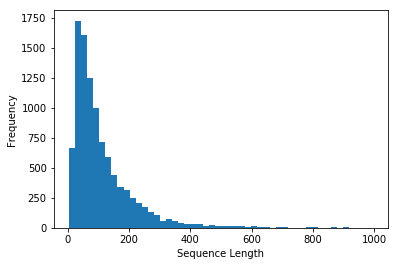

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

We can also use the Matplot library to visualize this data in a histogram format. 

From the histogram as well as the average number of words per file, we can safely say that most reviews will fall under 250 words, which is the max sequence length value we will set. 

In [5]:
maxSeqLength = 250

Let's see how we can take a single file and transform it into our ids matrix. This is what one of the reviews looks like in text file format.

Now, let's convert to to an ids matrix

In [6]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

Now, let's do the same for each of our 25,000 reviews. We'll load in the movie training set and integerize it to get a 25000 x 250 matrix. This was a computationally expensive process, so instead of having you run the whole piece, we’re going to load in a pre-computed IDs matrix.

In [7]:
numReviews = len(text)
ids = np.zeros((numReviews, maxSeqLength), dtype='int32')
reviewCounter = 0
for line in text:
    indexCounter = 0
    cleanedLine = cleanSentences(line)
    split = cleanedLine.split()
    for word in split:
        try:
            ids[reviewCounter][indexCounter] = wordsList.index(word)
        except ValueError:
            ids[reviewCounter][indexCounter] = 399999 #Vector for unkown words
        indexCounter = indexCounter + 1
        if indexCounter >= maxSeqLength:
            break
    reviewCounter = reviewCounter + 1 

#Pass into embedding function and see if it evaluates. 

np.save('idsMatrixPN', ids)

In [8]:
ids = np.load('idsMatrixPN.npy')

In [9]:
ids.shape

(5889, 250)

In [19]:
ids[1:2].shape

(1, 250)

# Helper Functions

Below you can find a couple of helper functions that will be useful when training the network in a later step. 

In [35]:
from random import randint

def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(1,79)
        onehot = np.zeros(5)
        onehot[ylabels[num-1]-1] = 1
        labels.append(list(onehot))
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(80,99)
        onehot = np.zeros(5)
        onehot[ylabels[num-1]-1] = 1
        labels.append(list(onehot))
        arr[i] = ids[num-1:num]
    return arr, labels

the block below is for pos_neg samples

In [12]:
from random import randint

def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(1,3999)
        if ylabels[num-1] == 1:
            onehot = [0,1]
        else:
            onehot = [1,0]
        labels.append(onehot)
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(4000,5888)
        if ylabels[num-1] == 1:
            onehot = [0,1]
        else:
            onehot = [1,0]
        labels.append(onehot)
        arr[i] = ids[num-1:num]
    return arr, labels

# RNN Model

Now, we’re ready to start creating our Tensorflow graph. We’ll first need to define some hyperparameters, such as batch size, number of LSTM units, number of output classes, and number of training iterations. 

In [34]:
batchSize = 20
lstmUnits = 64
numClasses = 2
iterations = 10000

As with most Tensorflow graphs, we’ll now need to specify two placeholders, one for the inputs into the network, and one for the labels. The most important part about defining these placeholders is understanding each of their dimensionalities. 

The labels placeholder represents a set of values, each either [1, 0] or [0, 1], depending on whether each training example is positive or negative. Each row in the integerized input placeholder represents the integerized representation of each training example that we include in our batch.

![caption](Images/SentimentAnalysis12.png)

In [35]:
import tensorflow as tf
tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

Once we have our input data placeholder, we’re going to call the tf.nn.lookup() function in order to get our word vectors. The call to that function will return a 3-D Tensor of dimensionality batch size by max sequence length by word vector dimensions. In order to visualize this 3-D tensor, you can simply think of each data point in the integerized input tensor as the corresponding D dimensional vector that it refers to. 


![caption](Images/SentimentAnalysis13.png)

In [36]:
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

Now that we have the data in the format that we want, let’s look at how we can feed this input into an LSTM network. We’re going to call the tf.nn.rnn_cell.BasicLSTMCell function. This function takes in an integer for the number of LSTM units that we want. This is one of the hyperparameters that will take some tuning to figure out the optimal value. We’ll then wrap that LSTM cell in a dropout layer to help prevent the network from overfitting. 

Finally, we’ll feed both the LSTM cell and the 3-D tensor full of input data into a function called tf.nn.dynamic_rnn. This function is in charge of unrolling the whole network and creating a pathway for the data to flow through the RNN graph.

In [37]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

As a side note, another more advanced network architecture choice is to stack multiple LSTM cells on top of each other. This is where the final hidden state vector of the first LSTM feeds into the second. Stacking these cells is a great way to help the model retain more long term dependence information, but also introduces more parameters into the model, thus possibly increasing the training time, the need for additional training examples, and the chance of overfitting. For more information on how you can add stacked LSTMs to your model, check out Tensorflow's excellent [documentation](https://www.tensorflow.org/tutorials/recurrent#stacking_multiple_lstms).

The first output of the dynamic RNN function can be thought of as the last hidden state vector. This vector will be reshaped and then multiplied by a final weight matrix and a bias term to obtain the final output values.

In [38]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

Next, we’ll define correct prediction and accuracy metrics to track how the network is doing. The correct prediction formulation works by looking at the index of the maximum value of the 2 output values, and then seeing whether it matches with the training labels. 

In [39]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

We’ll define a standard cross entropy loss with a softmax layer put on top of the final prediction values. For the optimizer, we’ll use Adam and the default learning rate of .001. 

In [40]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

If you’d like to use Tensorboard to visualize the loss and accuracy values, you can also run and the modify the following code. 

In [41]:
with tf.Session() as sess:
    pass

In [42]:
import datetime

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

# Hyperparameter Tuning

Choosing the right values for your hyperparameters is a crucial part of training deep neural networks effectively. You'll find that your training loss curves can vary with your choice of optimizer (Adam, Adadelta, SGD, etc), learning rate, and network architecture. With RNNs and LSTMs in particular, some other important factors include the number of LSTM units and the size of the word vectors.

* Learning Rate: RNNs are infamous for being diffult to train because of the large number of time steps they have. Learning rate becomes extremely important since we don't want our weight values to fluctuate wildly as a result of a large learning rate, nor do we want a slow training process due to a low learning rate. The default value of 0.001 is a good place to start. You should increase this value if the training loss is changing very slowly, and decrease if the loss is unstable.  
* Optimizer: There isn't a consensus choice among researchers, but Adam has been widely popular due to having the adaptive learning rate property (Keep in mind that optimal learning rates can differ with the choice of optimizer).
* Number of LSTM units: This value is largely dependent on the average length of your input texts. While a greater number of units provides more expressibility for the model and allows the model to store more information for longer texts, the network will take longer to train and will be computationally expensive. 
* Word Vector Size: Dimensions for word vectors generally range from 50 to 300. A larger size means that the vector is able to encapsulate more information about the word, but you should also expect a more computationally expensive model. 

# Training

The basic idea of the training loop is that we first define a Tensorflow session. Then, we load in a batch of reviews and their associated labels. Next, we call the session’s `run` function. This function has two arguments. The first is called the "fetches" argument. It defines the value we’re interested in computing. We want our optimizer to be computed since that is the component that minimizes our loss function. The second argument is where we input our `feed_dict`. This data structure is where we provide inputs to all of our placeholders. We need to feed our batch of reviews and our batch of labels. This loop is then repeated for a set number of training iterations.

Instead of training the network in this notebook (which will take at least a couple of hours), we’ll load in a pretrained model.

If you decide to train this notebook on your own machine, note that you can track its progress using [TensorBoard](https://www.tensorflow.org/get_started/summaries_and_tensorboard). While the following cell is running, use your terminal to enter the directory that contains this notebook, enter `tensorboard --logdir=tensorboard`, and visit http://localhost:6006/ with a browser to keep an eye on your training progress.

In [43]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

for i in range(iterations):
    #Next Batch of reviews
    nextBatch, nextBatchLabels = getTrainBatch();
    sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})
   
    #Write summary to Tensorboard
    if (i % 50 == 0):
        summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
        writer.add_summary(summary, i)

    #Save the network every 10,000 training iterations
    if (i % 10000 == 0 and i != 0):
        save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
        print("saved to %s" % save_path)
writer.close()

# Loading a Pretrained Model

Our pretrained model’s accuracy and loss curves during training can be found below. 

![caption](Images/SentimentAnalysis6.png)
![caption](Images/SentimentAnalysis7.png)

Looking at the training curves above, it seems that the model's training is going well. The loss is decreasing steadily, and the accuracy is approaching 100 percent. However, when analyzing training curves, we should also pay special attention to the possibility of our model overfitting the training dataset. Overfitting is a common phenomenon in machine learning where a model becomes so fit to the training data that it loses the ability to generalize to the test set. This means that training a network until you achieve 0 training loss might not be the best way to get an accurate model that performs well on data it has never seen before. Early stopping is an intuitive technique commonly used with LSTM networks to combat this issue. The basic idea is that we train the model on our training set, while also measuring its performance on the test set every now and again. Once the test error stops its steady decrease and begins to increase instead, you'll know to stop training, since this is a sign that the network has begun to overfit. 

Loading a pretrained model involves defining another Tensorflow session, creating a Saver object, and then using that object to call the restore function. This function takes into 2 arguments, one for the current session, and one for the name of the saved model. 

In [ ]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('models'))

Then we’ll load some movie reviews from our test set. Remember, these are reviews that the model has not been trained on and has never seen before. The accuracy for each test batch can be seen when you run the following code. 

In [32]:
iterations = 10
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

Accuracy for this batch: 85.00000238418579
Accuracy for this batch: 55.000001192092896
Accuracy for this batch: 64.99999761581421
Accuracy for this batch: 69.9999988079071
Accuracy for this batch: 75.0
Accuracy for this batch: 80.0000011920929
Accuracy for this batch: 69.9999988079071
Accuracy for this batch: 75.0
Accuracy for this batch: 85.00000238418579
Accuracy for this batch: 75.0


In [33]:
iterations = 10
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

Accuracy for this batch: 64.99999761581421
Accuracy for this batch: 64.99999761581421
Accuracy for this batch: 75.0
Accuracy for this batch: 89.99999761581421
Accuracy for this batch: 80.0000011920929
Accuracy for this batch: 85.00000238418579
Accuracy for this batch: 69.9999988079071
Accuracy for this batch: 60.00000238418579
Accuracy for this batch: 64.99999761581421
Accuracy for this batch: 85.00000238418579


10k iterations

In [44]:
iterations = 10
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

Accuracy for this batch: 60.00000238418579
Accuracy for this batch: 80.0000011920929
Accuracy for this batch: 85.00000238418579
Accuracy for this batch: 80.0000011920929
Accuracy for this batch: 75.0
Accuracy for this batch: 55.000001192092896
Accuracy for this batch: 89.99999761581421
Accuracy for this batch: 85.00000238418579
Accuracy for this batch: 80.0000011920929
Accuracy for this batch: 85.00000238418579


In [45]:
iterations = 10
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

Accuracy for this batch: 69.9999988079071
Accuracy for this batch: 94.9999988079071
Accuracy for this batch: 75.0
Accuracy for this batch: 85.00000238418579
Accuracy for this batch: 80.0000011920929
Accuracy for this batch: 80.0000011920929
Accuracy for this batch: 80.0000011920929
Accuracy for this batch: 69.9999988079071
Accuracy for this batch: 80.0000011920929
Accuracy for this batch: 69.9999988079071


# Conclusion

In this notebook, we went over a deep learning approach to sentiment analysis. We looked at the different components involved in the whole pipeline and then looked at the process of writing Tensorflow code to implement the model in practice. Finally, we trained and tested the model so that it is able to classify movie reviews.

With the help of Tensorflow, you can create your own sentiment classifiers to understand the large amounts of natural language in the world, and use the results to form actionable insights. Thanks for reading and following along!